In [1]:
!wget --no-check-certificate \
  https://github.com/Kawanua-project/KawanuaML/archive/valerie.zip \
  -O /tmp/KawanuaML.zip

--2023-12-07 16:08:55--  https://github.com/Kawanua-project/KawanuaML/archive/valerie.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Kawanua-project/KawanuaML/zip/refs/heads/valerie [following]
--2023-12-07 16:08:56--  https://codeload.github.com/Kawanua-project/KawanuaML/zip/refs/heads/valerie
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/KawanuaML.zip’

/tmp/KawanuaML.zip      [           <=>      ] 193.68M  19.9MB/s    in 8.8s    

2023-12-07 16:09:05 (22.0 MB/s) - ‘/tmp/KawanuaML.zip’ saved [203089138]



In [2]:
!unzip /tmp/KawanuaML.zip -d /tmp && rm /tmp/KawanuaML.zip

Archive:  /tmp/KawanuaML.zip
b18d6da892996e95007ede40c967afa520dd9d40
   creating: /tmp/KawanuaML-valerie/
   creating: /tmp/KawanuaML-valerie/Datasets/
   creating: /tmp/KawanuaML-valerie/Datasets/Hewan/
   creating: /tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/
  inflating: /tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/04e5ec1e-ebcb-4f34-a411-5ea64d14e79b.jpg  
  inflating: /tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/08477fb0-3509-432f-a533-870ac05af201.jpg  
  inflating: /tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/0ac1a37b-455d-4910-9e1c-803b16882c82.JPEG  
  inflating: /tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/0b7704ef-057a-4ab3-980e-52ce9eb6774d.jpg  
  inflating: /tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/0d899913-3f98-49a3-83d4-fa957144e694.JPEG  
  inflating: /tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/0e0d524e-0261-41f7-a8d3-f65b5ad7abbd.JPEG  
  inflating: /tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/0f09217d-945d-4e91-9e82-3e6dc3f105eb.JPEG  
 

In [3]:
#Install split folders
!pip install split_folders

In [4]:
# Import library yang diperlukan
import splitfolders as sf
import os

# Path awal dataset
base_dir = '/tmp/KawanuaML-valerie/Datasets/Hewan'

# Path untuk menyimpan dataset yang telah dibagi
output_dir = '/tmp/KawanuaML-valerie/image'

# Memastikan direktori output ada atau belum, jika belum, buat direktori
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Menggunakan split-folders untuk membagi dataset menjadi train dan validation set
sf.ratio(
    input=base_dir,
    output=output_dir,
    seed=None,
    ratio=(0.8, 0.2),
    group_prefix=None  # Tidak menggunakan grouping
)

Copying files: 1000 files [00:00, 3454.03 files/s]


In [5]:
from keras.preprocessing.image import ImageDataGenerator

# Mengatur direktori train dan validation untuk masing-masing kategori
image_dir = '/tmp/KawanuaML-valerie/image'

train_dir = os.path.join(output_dir, 'train')
validation_dir = os.path.join(output_dir, 'val')

# Pembuatan ImageDataGenerator dengan normalisasi dan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Menggunakan ImageDataGenerator untuk memuat gambar dari direktori dan menerapkan normalisasi dan augmentasi
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
print(os.listdir(train_dir))
print(os.listdir(validation_dir))

['GajahAsia', 'Orangutan']
['GajahAsia', 'Orangutan']


In [7]:
!rm -rf /tmp/KawanuaML-valerie/Datasets/Hewan/.ipynb_checkpoints

In [8]:
#membuat model
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers
from tensorflow.keras import Model

In [9]:
#load pretrained model
pretrained_model = MobileNet(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')

#freeze layer yang ada di pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

#menambahkan layer model
x = layers.GlobalAveragePooling2D()(pretrained_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

#menggabungkan model
model = Model(pretrained_model.input, output)

# Menampilkan ringkasan model
model.summary()

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

In [10]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
25/25 [==============================] - 58s 2s/step - loss: 0.1686 - accuracy: 0.9350 - val_loss: 0.0325 - val_accuracy: 0.9850
Epoch 2/5
25/25 [==============================] - 53s 2s/step - loss: 0.0289 - accuracy: 0.9887 - val_loss: 0.0310 - val_accuracy: 0.9800
Epoch 3/5
25/25 [==============================] - 55s 2s/step - loss: 0.0250 - accuracy: 0.9887 - val_loss: 0.0374 - val_accuracy: 0.9800
Epoch 4/5
25/25 [==============================] - 54s 2s/step - loss: 0.0306 - accuracy: 0.9912 - val_loss: 0.0450 - val_accuracy: 0.9850
Epoch 5/5
25/25 [==============================] - 55s 2s/step - loss: 0.0234 - accuracy: 0.9925 - val_loss: 0.0139 - val_accuracy: 0.9900


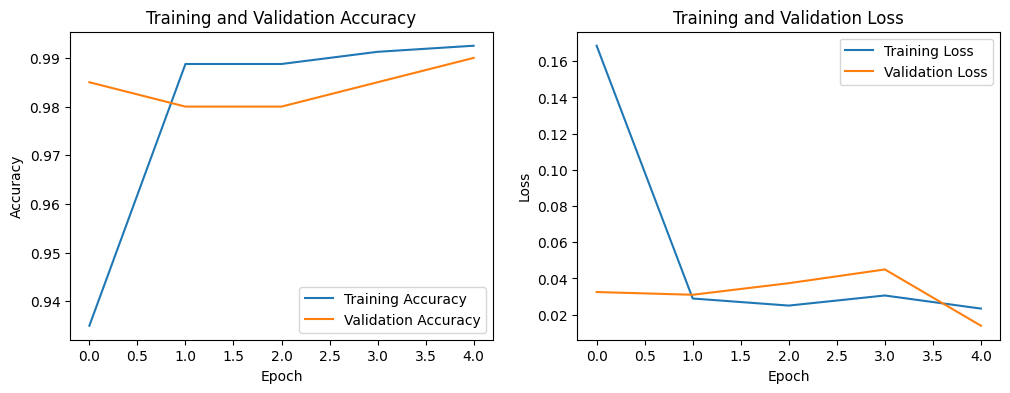

In [11]:
# Visualize accuracy and loss plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss         = history.history['loss']
val_loss     = history.history['val_loss']

epoch        = 5
epoch_range  = range(epoch)

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, accuracy, label='Training Accuracy')
plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss,     label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [15]:
import numpy as np
from keras.preprocessing import image

# Load and preprocess the input image
img_path = '/tmp/KawanuaML-valerie/Datasets/Hewan/GajahAsia/0f09217d-945d-4e91-9e82-3e6dc3f105eb.JPEG'
img = image.load_img(img_path, target_size = (224, 224,3))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the pixel values


# Make the prediction
labels = ['Gajah Asia',
          'Orangutan']
prediction = model.predict(img_array)
index = np.argmax(prediction)
class_names = labels[index]


# Get the predicted class label
predicted_class = class_names

# Print the predicted class label
print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 56ms/step
Predicted Class: Gajah Asia


In [16]:
model.save("/tmp/KawanuaML-valerie/model-hewan.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
